# Mean Reversion

## Internal Bar Strength

### Theory

**IBS** can in someway predict bullish or bearish movement of feature. It' pretty simple to calculate:
$$
\text{IBS}=\frac{\text{Close}-\text{Low}}{\text{High}-\text{Low}}
$$

$$
\text{IBS} < 0.6 \rightarrow \text{potential bearish sentiment}
$$
$$
\text{IBS} \geq 0.6 \rightarrow \text{potential bullish sentiment}
$$

Bollinger Band integrate historical data to estimate when a mean reversal is probable. Bollinger is using 25-day moving average of high prices and its deviation from the scaled range of high and low moving average prices:

$$
\text{Band} = \text{MA}_{25}(\text{High})-(2.25\cdot\text{HL}_\text{avg})
$$
where
$$
\text{HL}_\text{avg}=\text{MA}_{25}(\text{High})-\text{MA}_{25}(\text{Low})
$$

### Fetch data

In [336]:
import yfinance as yf

ticker = "^GSPC"
ticker = "META"

data = yf.download(ticker, period="1y", interval="1d", group_by="column")
data.columns = data.columns.droplevel(1)  # drop second level of MultiIndex

/var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/ipykernel_1059/1047010976.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="1y", interval="1d", group_by="column")
[*********************100%***********************]  1 of 1 completed


In [337]:
print(data)

Price            Close        High         Low        Open    Volume
Date                                                                
2024-08-19  527.473938  529.845761  520.976167  525.072128   9879700
2024-08-20  524.932556  529.277724  524.085481  526.547023   7944400
2024-08-21  533.333801  537.559384  525.131905  525.351186  13423300
2024-08-22  530.114746  542.372759  526.786178  535.167452  15708300
2024-08-23  526.198242  538.027732  523.268272  535.087786  11323900
...                ...         ...         ...         ...       ...
2025-08-12  790.000000  793.669983  772.429993  773.000000  14563100
2025-08-13  780.080017  795.460022  778.229980  791.150024   8811800
2025-08-14  782.130005  787.809998  772.510010  777.880005   8116200
2025-08-15  785.229980  796.250000  780.820007  784.150024  13363500
2025-08-18  767.369995  775.804993  756.560120  775.320007  16433095

[250 rows x 5 columns]


### Prepare data to Bollinger Band

In [338]:
data['IBS'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
data['HL_avg'] = data['High'].rolling(window=25).mean() - data['Low'].rolling(window=25).mean()
data['Band'] = data['High'].rolling(window=25).mean() - (2.25 * data['HL_avg'])

In [339]:
print(data.tail())

Price            Close        High         Low        Open    Volume  \
Date                                                                   
2025-08-12  790.000000  793.669983  772.429993  773.000000  14563100   
2025-08-13  780.080017  795.460022  778.229980  791.150024   8811800   
2025-08-14  782.130005  787.809998  772.510010  777.880005   8116200   
2025-08-15  785.229980  796.250000  780.820007  784.150024  13363500   
2025-08-18  767.369995  775.804993  756.560120  775.320007  16433095   

Price            IBS     HL_avg        Band  
Date                                         
2025-08-12  0.827214  14.640801  707.944197  
2025-08-13  0.107373  14.737600  710.043598  
2025-08-14  0.628758  14.701599  712.205001  
2025-08-15  0.285805  14.700400  715.051299  
2025-08-18  0.561702  15.012195  716.261961  


### Backtesting strategy

**In this backtesting we are skipping taxes and brokerage commissions.**
1. For loop to simulate every day from 25th day to end of list.
2. If position on market doesn't exist + IBS is below 0.6 and closing price is below Band then buy.
3. If position on market exist + today closing price is higher than High price from yesterday then sell.

In [340]:
import numpy as np
import pandas as pd

is_position = False
assets_num = 0
wallet = 1000

backtesting_data = {'Entry': [np.nan for _ in range(25)], 'Exit': [np.nan for _ in range(25)]}

for i in range(25, len(data)):
    if not is_position and data['IBS'].iloc[i] < 0.6 and data['Close'].iloc[i] < data['Band'].iloc[i]:
        is_position = True
        assets_num = wallet / data['Close'].iloc[i]
        wallet = 0
        backtesting_data['Entry'].append(data['Close'].iloc[i])
    else:
        backtesting_data['Entry'].append(np.nan)

    if is_position and data['Close'].iloc[i] > data['High'].iloc[i - 1]:
        is_position = False
        wallet = assets_num * data['Close'].iloc[i]
        assets_num = 0
        backtesting_data['Exit'].append(data['Close'].iloc[i])
    else:
        backtesting_data['Exit'].append(np.nan)

    


In [341]:
print(wallet)

1127.7344762222842


In [342]:
print(len(backtesting_data['Entry']), "entries")
print(len(backtesting_data['Exit']), "exits")
print(len(data), "days")

250 entries
250 exits
250 days


### Visualization of Backtesting Results

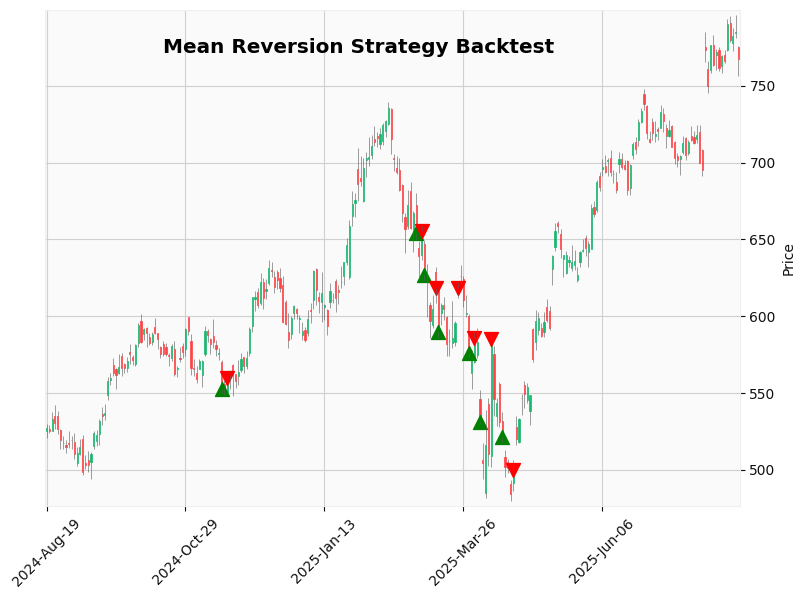

In [343]:
import mplfinance as mpf

ap = [
    mpf.make_addplot(backtesting_data['Entry'], type='scatter', markersize=100, marker='^', color='g'),
    mpf.make_addplot(backtesting_data['Exit'], type='scatter', markersize=100, marker='v', color='r')
]


mpf.plot(
    data,
    type='candle',
    addplot=ap,
    volume=False,
    style='yahoo',
    title='Mean Reversion Strategy Backtest',
    tight_layout=True
)